In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt #for file handling and displaying the image

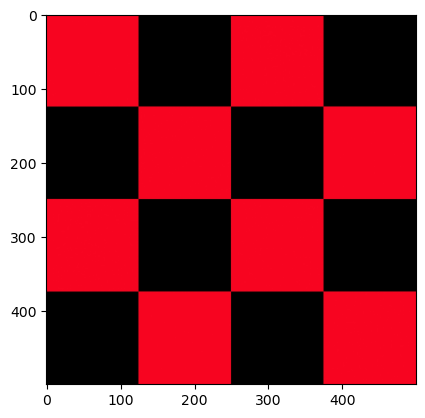

In [13]:
#2.1: Find an image on-line that displays a checkerboard (provide source website). 

#opening our checkerboard
#using .ppm because it's easy to parse
#(and because I have an old p3 .ppm parser in C++... which actually didn't come in that handy. whoops)
#EDIT found out i could just use matplotlib as it falls under "file handling" . but i have a ppm loader for 2.1 now. please appreciate it.
def load_ppm(filepath):
    lineCount = 0
    #screenx, screeny = 0
    with open(filepath, "r") as file:
        line = file.readline().strip(); #P3/P6
        if (line != "P3"):
            return "Error: Use a P3 .ppm file instead."
        line = file.readline().strip(); #this would be the filename
        while True: #size is next; X by Y
            line = file.readline().strip(); 
            if not line.startswith("#"):
                screenx, screeny = map(int, line.split())
                break;
        while True: #max colors
            line = file.readline().strip(); 
            if not line.startswith("#"):
                maxColors = int(line);
                break;
        pixels = []
        for line in file: #now our R G B values for each pixel
            if not line.startswith("#"):
                pixels.extend(map(int, line.split()))
        img_array = np.array(pixels, dtype=np.uint8).reshape((screeny, screenx, 3))
    return img_array

image_array = load_ppm(".\checkerboard_from_publicdomainpicturesnet.ppm")

plt.imshow(image_array)
plt.savefig("plain_checkerboard.png")

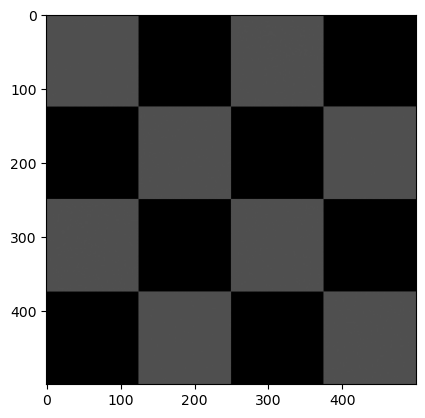

In [14]:
#2.1 cont: Convert to gray-scale if it is colour
def make_her_grayscale(pixel_array):
    gray = np.dot(pixel_array[..., :3], [0.30, 0.59, 0.11]).astype(np.uint8)
    return np.stack([gray] * 3, axis=-1) #returns us to our previous dimensionality (since we're using ppm and need 3 channels)
    #and also since matplotlib uses a colormap on grayscale images and I feel like color=gray is kinda cheating

gray_array = make_her_grayscale(image_array)

plt.imshow(gray_array)
plt.savefig("gray_checkerboard.png")

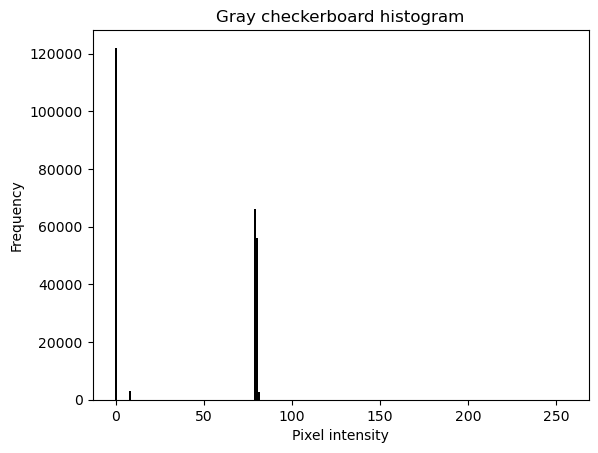

In [15]:
#2.2 Write a program to compute the histogram.
def compute_histogram(img_array):
     #we could also just do this
    histogram = np.histogram(img_array)
    # buuuut I think bastiaan wanted us to avoid convenient methods. soo

    #reducing dimensionality to grayscale
    if img_array.ndim == 3:
        img_array = img_array[:, :, 0]
    
    #what we're adding our unique counts to
    hist_map = np.zeros(256, dtype=np.uint32)

    #gets us our counts of every repeated intensity
    uniques, counts = np.unique(img_array, return_counts=True)

    #for every index that equals an intensity we found in the image,
    #set it equal to the number of pixels with that intensity
    hist_map[uniques] = counts

    #create a new array 0-255 to represent our intensities on the x axis
    #our counts (hist_map) will be our y axis
    intensities = np.arange(256)
    
    #world's ugliest histogram.
    bar = plt.bar(intensities, hist_map, color='black', width=1.0)
    plt.xlabel("Pixel intensity")
    plt.ylabel("Frequency")
    return bar
    

bar = compute_histogram(gray_array)
plt.title("Gray checkerboard histogram")
plt.savefig("gray_histogram.png")

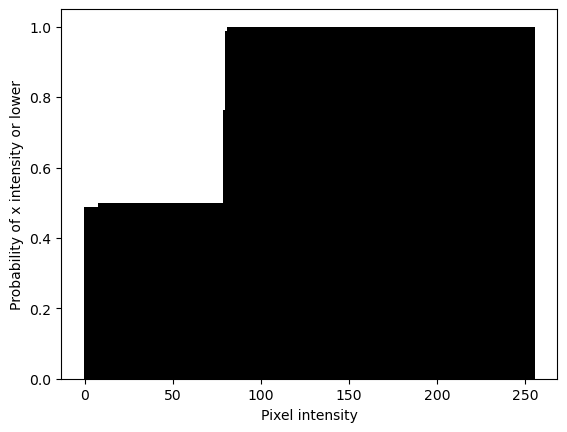

In [16]:
#2.2 cont: and a program to compute the cumulative probability function of the image and display result.
#pretty much identical to the histogram method
def compute_cdf(img_array):
    uniques, counts = np.unique(img_array, return_counts=True)

    #adding up all our counts so we can calc probability of a specific unique:count later
    total = 0
    for count in counts:
        total += count

    #getting the probability for each frequency to be chosen
    probabilities  = counts / total;

    #matching each probability to their respective intensity index
    pmf = np.zeros(256, dtype=float)
    pmf[uniques] = probabilities

    #technically we could do this. but it would be against instructions i think
    cdf = np.cumsum(pmf)

    #now to calculate the cpf
    #aka the likelihood of choosing X or anything less than X
    total = 0
    cdf = []
    for probability in pmf:
        total += probability
        cdf.append(total)

    #create a new array 0-255 to represent our intensities on the x axis
    #our cumulative probabilities will be our y axis
    intensities = np.arange(256)
    #looks kinda funny. reblog
    bar = plt.bar(intensities, cdf, color='black', width=1.0)
    plt.xlabel("Pixel intensity")
    plt.ylabel("Probability of x intensity or lower")
    plt.savefig("cpf.png")
    return cdf, bar

cpf = compute_cdf(gray_array)

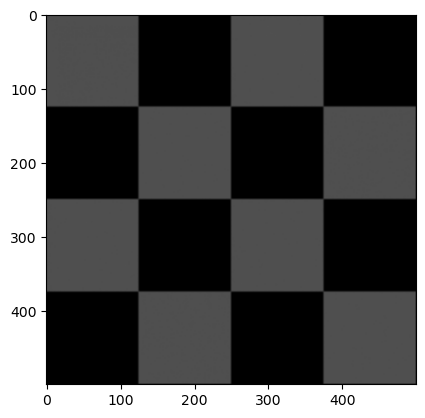

In [17]:
#Write a program to low-pass filter (smooth) the image in the spatial domain. You can select the filter.
#I selected a box filter :)
def low_pass(img_array, kernelSize):
    #reducing dimensionality
    img_array = img_array[:, :, 0]
    
    height, width = img_array.shape

    #making our box kernel
    kernel = np.ones((kernelSize, kernelSize)) / (kernelSize*kernelSize)

    #create a padded version of the image (so edge pixels will have neighbors)
    padded_image = np.pad(img_array, pad_width=1, mode='constant', constant_values=0)

    #empty image we'll fill up slice by slice
    filtered_img = np.zeros_like(image_array)

    for i in range(height):
        for j in range(width):
            slice = padded_image[i:i+kernelSize,j:j+kernelSize]
            filtered = np.sum(slice * kernel)

            filtered_img[i,j] = filtered
            
            
    plt.imshow(filtered_img)
    plt.savefig("2d_filtered_checkerboard.png")
    return filtered_img

#setting kernel size to 3
twod_filter = low_pass(gray_array, 3)

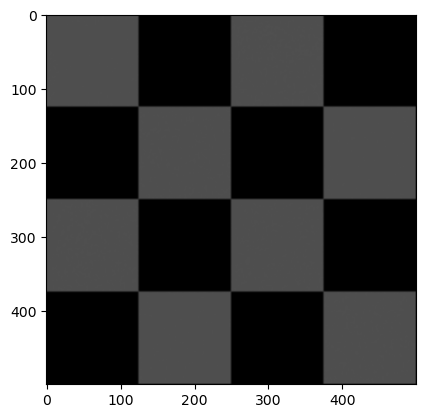

In [18]:
#2.4: Explain if the low-pass filter you selected is separable.
#I did more than I should have for this but I wanted to prove it programmatically.
def separable_filter(img_array):
    #reducing dimensionality to grayscale
    #img_array = img_array[:, :, 0]
    
    height, width, _ = img_array.shape

    kernelSize = 3

    #showing that we can rewrite the kernel as separate 1D vectors
    vertical_kernel = np.ones((kernelSize, 1)) / (kernelSize*kernelSize)
    horizontal_kernel = np.ones((1, kernelSize)) / (kernelSize*kernelSize)

    #create a padded version of the image
    #we gotta pad so edge pixels will have neighbors. note that I'm using a different method to pad; this is why I didn't decrease dimensionality
    #np.pad throws a hissyfit if you don't have a third dimension...
    padded_image = np.pad(img_array, ((1, 1), (0, 0), (0,0)), mode='constant', constant_values=0)
    #print(padded_image.shape)

    #empty image we'll fill up vertically slice by slice
    vertical_pass = np.zeros_like(image_array)

    #vertical filter
    for i in range(height):
        for j in range(width):
            slice = padded_image[i:i+kernelSize,j]
            #print(f"slice.shape {slice.shape} vertical_kernel.shape {vertical_kernel.shape}")
            vertical_pass[i,j] = np.sum(slice * vertical_kernel)

    #okay. horizontal pass now
    #print(vertical_pass.shape)
    padded_vertical = np.pad(vertical_pass, ((0, 0), (1, 1), (0,0)), mode='constant', constant_values=0)
    horizontal_pass = np.zeros_like(image_array)

    #horizontal filter
    for i in range(height):
        for j in range(width):
            slice = padded_vertical[i,j:j+kernelSize]
            #print(f"slice.shape {slice.shape} vertical_kernel.shape {vertical_kernel.shape}")
            horizontal_pass[i,j] = np.sum(slice * horizontal_kernel)
    
    plt.imshow(horizontal_pass)
    plt.savefig("separable_filtered_checkerboard.png")
    return horizontal_pass
    
oned_filter = separable_filter(gray_array)

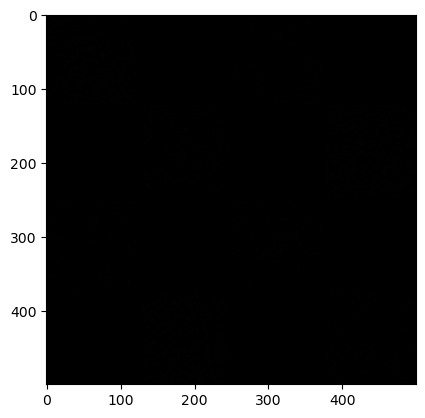

In [19]:
#2.4: Explain if the low-pass filter you selected is separable.
difference = np.abs(twod_filter.astype(np.int8) - oned_filter.astype(np.int8))
#the original box filter minus the separable box filter is just a black square, proving these got identical outputs.
plt.imshow(difference, cmap="gray")
plt.savefig("separable_difference_checkerboard.png")

C:\Users\alexw\AppData\Local\Temp\ipykernel_22064\2527810625.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  filtered_image = np.abs(filtered_image.astype(int))


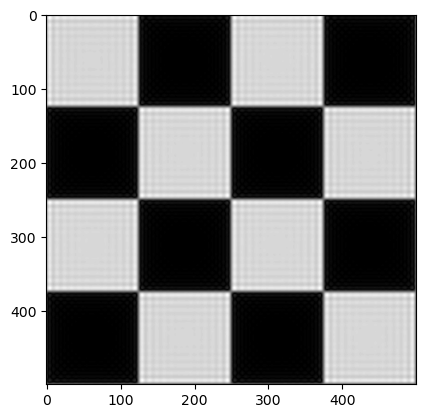

In [20]:
#2.5: Write a program to perform the same low-pass filtering in the frequency domain (may use a library for the DFT/FFT operator).
def DFT_image(img_array, kernelSize):
    #reducing dimensionality
    img_array = img_array[:, :, 0]
    
    #converting to the frequency domain using numpy
    freq_array = np.fft.fft2(img_array)
    fshift = np.fft.fftshift(freq_array)

    #getting the shape so we can make our mask
    height, width = img_array.shape

    #will give us 50,50 with a 500x500 image
    paddingH, paddingW = height // 10, width // 10

    #100x100 box of 1s that will go in the center of the mask
    ones_box = np.ones((2 * paddingH, 2 * paddingW), dtype=np.uint8)

    boxH, boxW = ones_box.shape

    #calculating how far each of the edges of the 1s box need to be padded to match the shape of our image
    pad_top = (height - boxH) // 2
    pad_bottom = height - boxH - pad_top
    pad_left = (width - boxW) // 2
    pad_right = width - boxW - pad_left

    #padding the ones box with 0s out to reach the size/shape of our image to make our mask
    mask = np.pad(ones_box, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant')

    #applying mask by doing multiplication
    fshift_masked = fshift * mask 

    #inversing fft shift (we're going spatial style)
    f_ishift = np.fft.ifftshift(fshift_masked) 
    filtered_image = np.fft.ifft2(f_ishift)

    #we have crazy -20.3242e33 40.2940e20 values rn, this gets the absolute values and chops them to ints
    filtered_image = np.abs(filtered_image.astype(int)) 

    return filtered_image

filtered_image = DFT_image(gray_array, 3)
plt.imshow(filtered_image, cmap="gray")
plt.savefig("dft_checkerboard.png")

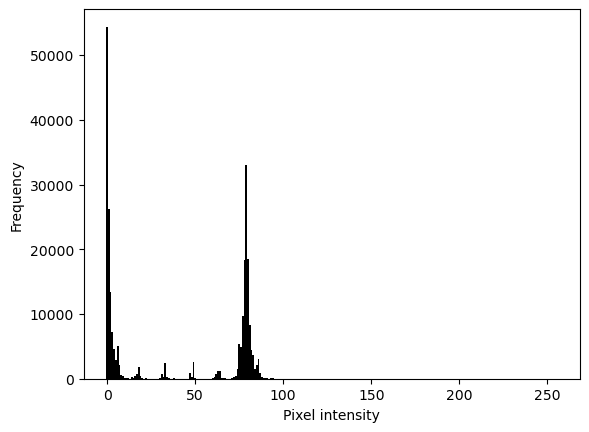

In [21]:
#2.6: Compute the histogram of the low-pass filtered checkerboard image.
bar = compute_histogram(filtered_image)
plt.savefig("dft_histogram.png")

C:\Users\alexw\AppData\Local\Temp\ipykernel_22064\4090899855.py:36: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -16 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  new_image[i,j] = math.floor((cdf[intensity] - cdf[min_index] / (cdf[max_index] - cdf[min_index])) * 255)


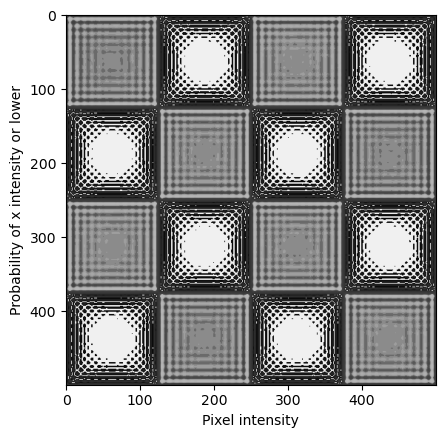

In [23]:
import math;

def equalize(img_array):
    #reducing dimensionality
    if img_array.ndim == 3:
        img_array = img_array[:, :, 0]
    
    #getting height/width of the image
    height, width = img_array.shape

    #pixel count of our image
    pixels = height * width

    #calculating alpha via https://archive.ph/20160516012012/http://www.generation5.org/content/2004/histogramEqualization.asp#selection-579.70-587.36
    alpha = 255 / pixels

    #getting our probabilities for each intensity
    cdf, _ = compute_cdf(img_array)

    min_index = np.argmin(cdf)

    max_index = np.argmax(cdf)
    
    #converting to numpy so we can get cumulative pixel counts easier
    cdf = np.array(cdf)

    #time for a new image
    new_image = np.zeros_like(image_array)

    for i in range(height):
        for j in range(width):
            #gray intensity of current pixel
            intensity = img_array[i,j]
            
            #print( math.floor((cdf[intensity - min_index] / (max_index - min_index)) * 255))
            new_image[i,j] = math.floor((cdf[intensity] - cdf[min_index] / (cdf[max_index] - cdf[min_index])) * 255)
            #print(img_array[i,j], new_image[i,j])

    plt.imshow(new_image)
    return new_image

equalised_image = equalize(filtered_image)
plt.savefig("equalised_checkerboard.png")
            

NameError: name 'plot' is not defined

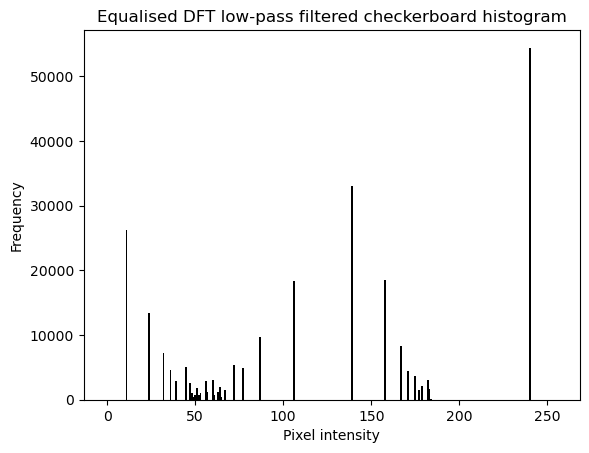

In [24]:
hist = compute_histogram(equalised_image)

plt.title("Equalised DFT low-pass filtered checkerboard histogram")
plt.savefig("equalised_histogram.png")
plot.show()

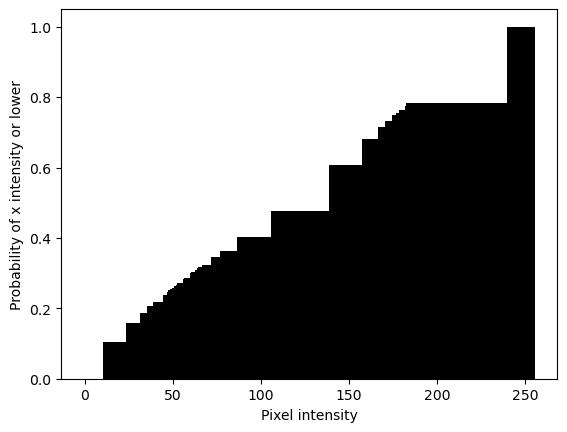

In [25]:
_, plot = compute_cdf(equalised_image)
plt.savefig("equalised_cdf.png")